# Titanic : Machine Learning from Disaster

## Workflow stages¶

1. Question or problem definition.
2. Acquire training and testing data.
3. Wrangle, prepare, cleanse the data.
4. Analyze, identify patterns, and explore the data.
5. Model, predict and solve the problem.
6. Visualize, report, and present the problem solving steps and final solution.
7. Supply or submit the results.

### Problem definition

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, **some groups of people were more likely to survive** than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the **analysis of what sorts of people were likely to survive**. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

### Training and testing data acquisition

In [1]:
# Libs loading
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, random as rnd, math, xxhash
%matplotlib inline

In [2]:
df_train, df_test = pd.read_csv("train.csv"), pd.read_csv("test.csv")

### Data preparation
In order to prepare the data, first we need information on the data itself. We're looking for:

- information on columns
- information on data distribution
- information on categorical variables

In [3]:
# Data information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
# Data distribution
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Allen, Miss. Elisabeth Walton",male,347082,G6,S
freq,1,577,7,4,644


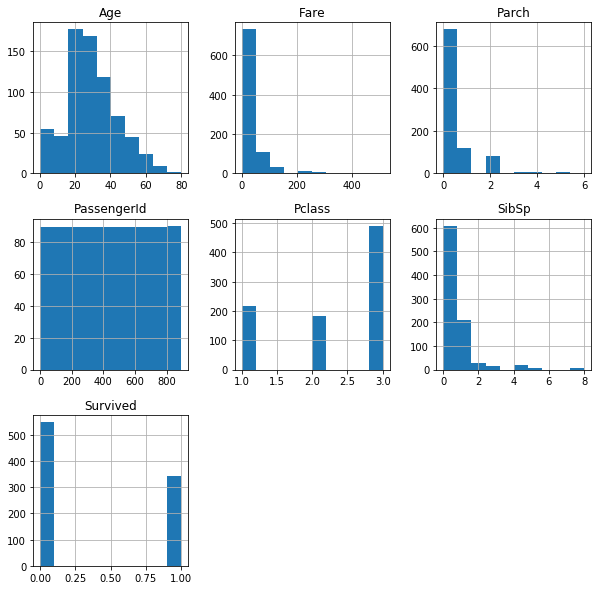

In [6]:
# Distribution of categorical variables
categorical_vars = df_train.describe(include=["object"]).columns
continuous_vars = df_train.describe().columns
_ = df_train.hist(column=continuous_vars, figsize = (10,10))

In [7]:
# Which values are Null?
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Many *age* values are not present, as well as *cabin*, and a few *Embarked*.

- *Embarked* missing values are just 2, I'd drop the two values.
- Since *Cabin* missing values are too many, I'd drop the feature.
- *Age* values can be filled, either by mean or by methods similar to KNN.

In [8]:
# Given our class of survival is 0/1, which feature correlate more with the survival rate?
correlation = df_train.corr(method='pearson')
correlation

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


### Preprocessing

In [9]:
# Drop labels 'Name' and 'Ticket' which are difficult to process
df_train.drop('Name', axis=1, inplace=True)
df_train.drop('Ticket', axis=1, inplace=True)

In [10]:
# Drop the *Cabin* attribute and the two entries with missing *Embarked*
df_train.drop('Cabin', axis=1, inplace=True)
df_train.drop(df_train[df_train.Embarked.isna()].index, inplace=True)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


The label *Embarked* is not a 0/1 value. We should encode it.

In [11]:
print(df_train['Embarked'].unique())
df_train['Embarked'] = df_train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
print(df_train['Embarked'].unique())

['S' 'C' 'Q']
[0 1 2]


The label *Sex* is not a 0/1 value. We should encode it.

In [12]:
print(df_train['Sex'].unique())
df_train['Sex'] = df_train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
print(df_train['Sex'].unique())

['male' 'female']
[0 1]


In [13]:
# Handling the 'Age' NULLs by using the mean of the people of the same Pclass and Sex
group_condition = ['Pclass', 'Sex', 'SibSp']
df_guess_age = df_train.dropna().groupby(group_condition, as_index=True).mean().reset_index()
df_guess_age = df_guess_age[group_condition+['Age']]
# df_guess_age[(df_guess_age.Pclass == 1) & (df_guess_age.SibSp == 1)]
df_guess_age.head()

,Pclass,Sex,SibSp,Age
0,1,0,0,42.738806
1,1,0,1,38.481290
2,1,0,2,47.000000
3,1,0,3,19.000000
4,1,1,0,33.272727


In [14]:
def age_mapper(entry):
    if str(entry['Age']) == 'nan':
        value = df_guess_age[(df_guess_age.Pclass == entry.Pclass) & (df_guess_age.Sex == entry.Sex) & (df_guess_age.SibSp == entry.SibSp)]
        if not value.empty:
            entry['Age'] = round(value.Age.values[0],0)
        else:
            value = df_guess_age[(df_guess_age.Pclass == entry.Pclass) & (df_guess_age.Sex == entry.Sex)].mean()
            entry['Age'] = round(value.Age, 0)
    return entry

print(df_train['Age'].isnull().sum())
df_train = df_train.apply(lambda x : age_mapper(x), axis=1)
print(df_train['Age'].isnull().sum())

177
0


#### New feature: age group

Let's create a new feature, *age group* and test the correlation with the target label *survived*.

In [15]:
df_train['AgeBand'] = pd.cut(df_train['Age'], 4)
df_train['AgeBand'].unique().sort_values()

[(0.34, 20.315], (20.315, 40.21], (40.21, 60.105], (60.105, 80.0]]
Categories (4, interval[float64]): [(0.34, 20.315] < (20.315, 40.21] < (40.21, 60.105] < (60.105, 80.0]]

In [16]:
my_map = {}
i = 0
for interv in df_train['AgeBand'].unique().sort_values():
    my_map[interv] = i
    i+=1
df_train['AgeBand'] = df_train['AgeBand'].map(lambda x : my_map[x])

df_train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand')

,AgeBand,Survived
0,0,0.434555
1,1,0.375000
2,2,0.369128
3,3,0.190476


In [17]:
# New feature : FareBand
df_train['FareBand'] = pd.cut(df_train['Fare'], 4)
df_train['FareBand'].unique().sort_values()

[(-0.512, 128.082], (128.082, 256.165], (256.165, 384.247], (384.247, 512.329]]
Categories (4, interval[float64]): [(-0.512, 128.082] < (128.082, 256.165] < (256.165, 384.247] < (384.247, 512.329]]

In [18]:
my_map = {}
i = 0
for interv in df_train['FareBand'].unique().sort_values():
    my_map[interv] = i
    i+=1
df_train['FareBand'] = df_train['FareBand'].map(lambda x : my_map[x])

df_train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand')

,FareBand,Survived
0,0,0.366627
1,1,0.724138
2,2,0.666667
3,3,1.000000


In [19]:
df_train.head(20)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand,FareBand
0,1.0,0.0,3.0,0.0,22.0,1.0,0.0,7.2500,0.0,1,0
1,2.0,1.0,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,1,0
2,3.0,1.0,3.0,1.0,26.0,0.0,0.0,7.9250,0.0,1,0
3,4.0,1.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,1,0
4,5.0,0.0,3.0,0.0,35.0,0.0,0.0,8.0500,0.0,1,0
5,6.0,0.0,3.0,0.0,29.0,0.0,0.0,8.4583,2.0,1,0
6,7.0,0.0,1.0,0.0,54.0,0.0,0.0,51.8625,0.0,2,0
7,8.0,0.0,3.0,0.0,2.0,3.0,1.0,21.0750,0.0,0,0
8,9.0,1.0,3.0,1.0,27.0,0.0,2.0,11.1333,0.0,1,0
9,10.0,1.0,2.0,1.0,14.0,1.0,0.0,30.0708,1.0,0,0


#### Side note: label through hashing
Another interesting approach would be, instead of encoding by mapping, to hash the values.
This allows for a dynamic mapping, which also takes into consideration the possibility of having new classes in the test dataset.

In [20]:
# Example of hashing, not actually used:
not_hashed = df_train['Embarked'].map( {0: 'S', 1: 'C', 2: 'Q'} ).astype(str)
hashed = not_hashed.map(lambda x : xxhash.xxh32(x).intdigest())
print(hashed.unique())

print(xxhash.xxh32('T').intdigest())

[3633353355  907964600  348624335]
1306257776


### Model & predictions

Since this is a binary problem, we will use only standard classifier models from the scikit-learn library.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score

In [22]:
# Separate features and target label
X_id = df_train['PassengerId']
X = df_train.drop(['Survived','PassengerId'], axis=1)
y = df_train['Survived'].copy()

# Two options to test accuracy: Holdout or CV - generate the splits with sklearn
from sklearn.model_selection import train_test_split as data_cv
X_train, X_test, y_train, y_test = data_cv(X, y, test_size=0.20, random_state=95)

In [23]:
n_iter = 5

# RandomForestClassifier
rfc = RandomForestClassifier()
# KNeighborsClassifier
knn = KNeighborsClassifier()
# MLPClassifier
mlp = MLPClassifier()
# SGDClassifier
gnb = GaussianNB()

classifiers = [rfc, knn, mlp, gnb]

    
acc = [0 for x in classifiers]
for i in range(0, n_iter):
    X_train, X_test, y_train, y_test = data_cv(X, y, test_size=0.20, random_state=math.floor(rnd.random()*100))
    for j in range(0,len(classifiers)):
        cl = classifiers[j]
        cl.fit(X_train, y_train)
        acc[j] += accuracy_score(y_test, cl.predict(X_test))
    
for j in range(0,len(classifiers)):
    acc[j] = acc[j] / n_iter
    print('Accuracy of model %d: '%j +str(acc[j]))

Accuracy of model 0: 0.8191011235955056
Accuracy of model 1: 0.7
Accuracy of model 2: 0.7910112359550562
Accuracy of model 3: 0.79438202247191


Feature ranking:
1. feature 5: Fare (0.283234)
2. feature 2: Age (0.254598)
3. feature 1: Sex (0.251885)
4. feature 0: Pclass (0.057071)
5. feature 3: SibSp (0.048979)
6. feature 6: Embarked (0.037514)
7. feature 4: Parch (0.031147)
8. feature 7: AgeBand (0.031105)
9. feature 8: FareBand (0.004467)


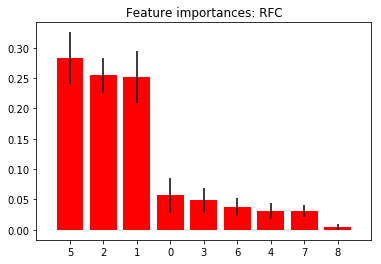

In [24]:
# Display feature importances of RFC
features = list(X_train.columns.values)
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances: RFC")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()